In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Định nghĩa các đường dẫn
PROJECT_ROOT = Path(r"D:\do-an-tot-nghiep")  
DATA_DIR     = PROJECT_ROOT / "dataset"
MODEL_OUT    = PROJECT_ROOT / "models" / "phobert"

# Tạo thư mục nếu chưa tồn tại
MODEL_OUT.mkdir(parents=True, exist_ok=True)

CLS_PATH = DATA_DIR / "summarize_data.csv"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"MODEL_OUT: {MODEL_OUT}")
print(f"CLS_PATH: {CLS_PATH}")


c:\Users\kyen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



PyTorch: 2.6.0+cu124
CUDA available: True
PROJECT_ROOT: D:\do-an-tot-nghiep
MODEL_OUT: D:\do-an-tot-nghiep\models\vit5_classification
CLS_PATH: D:\do-an-tot-nghiep\dataset\clean_data.csv


In [ ]:
# Load CSV với memory-efficient options
# Option 1: Chỉ load các cột cần thiết
df = pd.read_csv(
    CLS_PATH,
    usecols=['body', 'subject'],  # Chỉ load 2 cột cần thiết
    dtype={
        'body': str,
        'subject': str
    },
    engine='python',
    on_bad_lines='skip'
)

print("Shape dataset:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()


In [3]:
# Kiểm tra các cột bắt buộc
assert "target_text" in df.columns,  "Thiếu cột 'text' trong cls_phobert_data.csv"
assert "label" in df.columns, "Thiếu cột 'label' trong cls_phobert_data.csv"

# Làm sạch nhẹ
df["target_text"] = df["target_text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
df["label"] = df["label"].astype(str).str.strip()

# Bỏ mẫu rỗng
before = len(df)
df = df[(df["target_text"].str.len() > 0) & (df["label"].str.len() > 0)].reset_index(drop=True)
print(f"Bỏ {before - len(df)} mẫu text/label rỗng. Còn lại:", len(df))

print("\nPhân bố nhãn:")
print(df["label"].value_counts())


Bỏ 0 mẫu text/label rỗng. Còn lại: 11353

Phân bố nhãn:
label
Sức khỏe              1096
Kinh doanh            1094
Pháp luật             1062
Giải trí              1049
Đời sống              1029
Chính trị             1019
Du lịch               1011
Khoa học công nghệ    1008
Thế giới              1006
Thể thao              1001
Giáo dục               978
Name: count, dtype: int64


In [4]:
# Encode label string -> id (0..num_labels-1)
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

num_labels = len(label_encoder.classes_)
print("Số lớp:", num_labels)
print("Label classes:", list(label_encoder.classes_))

# Lưu label_encoder để dùng inference sau này
import joblib
LBL_PATH = MODEL_OUT / "label_encoder.pkl"
joblib.dump(label_encoder, LBL_PATH)
print("Đã lưu label_encoder:", LBL_PATH)


Số lớp: 11
Label classes: ['Chính trị', 'Du lịch', 'Giáo dục', 'Giải trí', 'Khoa học công nghệ', 'Kinh doanh', 'Pháp luật', 'Sức khỏe', 'Thế giới', 'Thể thao', 'Đời sống']
Đã lưu label_encoder: D:\do-an-tot-nghiep\models\phobert\label_encoder.pkl


Chia train/val/test và tạo DatasetDict

In [5]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"],
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["label_id"],
)

print("Train:", train_df.shape)
print("Val  :", val_df.shape)
print("Test :", test_df.shape)

# Tạo DatasetDict cho HuggingFace
train_ds = Dataset.from_pandas(train_df[["target_text", "label_id"]], preserve_index=False)
val_ds   = Dataset.from_pandas(val_df[["target_text", "label_id"]],   preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["target_text", "label_id"]],  preserve_index=False)

raw_datasets = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})

for split in raw_datasets:
    print(f"{split}: {len(raw_datasets[split])} mẫu")


Train: (9082, 4)
Val  : (1135, 4)
Test : (1136, 4)
train: 9082 mẫu
validation: 1135 mẫu
test: 1136 mẫu


Load PhoBERT tokenizer & model

In [6]:
PHOBERT_NAME = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(PHOBERT_NAME, use_fast=False)

config = AutoConfig.from_pretrained(
    PHOBERT_NAME,
    num_labels=num_labels,
    hidden_dropout_prob=0.2,           # Tăng dropout để giảm overfitting
    attention_probs_dropout_prob=0.2,  # Thêm attention dropout
)

model = AutoModelForSequenceClassification.from_pretrained(
    PHOBERT_NAME,
    config=config,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model device:", device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model device: cuda


Tokenize

In [7]:
MAX_LENGTH = 256 

def preprocess_function(batch):
    # tokenize text
    encodings = tokenizer(
        batch["target_text"],
        padding=False,
        truncation=True,
        max_length=MAX_LENGTH,
    )
    
    encodings["labels"] = batch["label_id"]
    return encodings

tokenized_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=["target_text"],  
    desc="Tokenizing",
)

for split in tokenized_datasets:
    print(split, tokenized_datasets[split][0].keys())


Tokenizing: 100%|██████████| 9082/9082 [00:08<00:00, 1025.22 examples/s]

Tokenizing: 100%|██████████| 1135/1135 [00:01<00:00, 931.40 examples/s]

Tokenizing: 100%|██████████| 1136/1136 [00:01<00:00, 937.16 examples/s]

train dict_keys(['label_id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])
validation dict_keys(['label_id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])
test dict_keys(['label_id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


Data collator & metric (Accuracy, F1)

In [8]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    pad_to_multiple_of=8,
)

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
    f1_weighted = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="weighted",
    )["f1"]

    return {
        "accuracy": acc,
        "f1": f1_weighted,
    }


TrainingArguments

In [10]:
LOG_DIR = MODEL_OUT / "runs"
LOG_DIR.mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir=str(MODEL_OUT),
    overwrite_output_dir=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=1,

    num_train_epochs=5,        
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=1,

    learning_rate=2e-5,      
    warmup_ratio=0.1,
    weight_decay=0.01,        

    lr_scheduler_type="cosine",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,

    fp16=torch.cuda.is_available(),   
    report_to="none",
)


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


C:\Users\kyen\AppData\Local\Temp\ipykernel_17568\3627228004.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.768600,0.565713,0.847577,0.845190
2,0.477800,0.474733,0.868722,0.865433
3,0.324600,0.452586,0.869604,0.867794
4,0.251100,0.449776,0.874009,0.872145
5,0.217600,0.467995,0.879295,0.876957


TrainOutput(global_step=2840, training_loss=0.5418359331681695, metrics={'train_runtime': 969.1723, 'train_samples_per_second': 46.854, 'train_steps_per_second': 2.93, 'total_flos': 5974287683879424.0, 'train_loss': 0.5418359331681695, 'epoch': 5.0})

Best val_loss: 0.4498 tại epoch 4


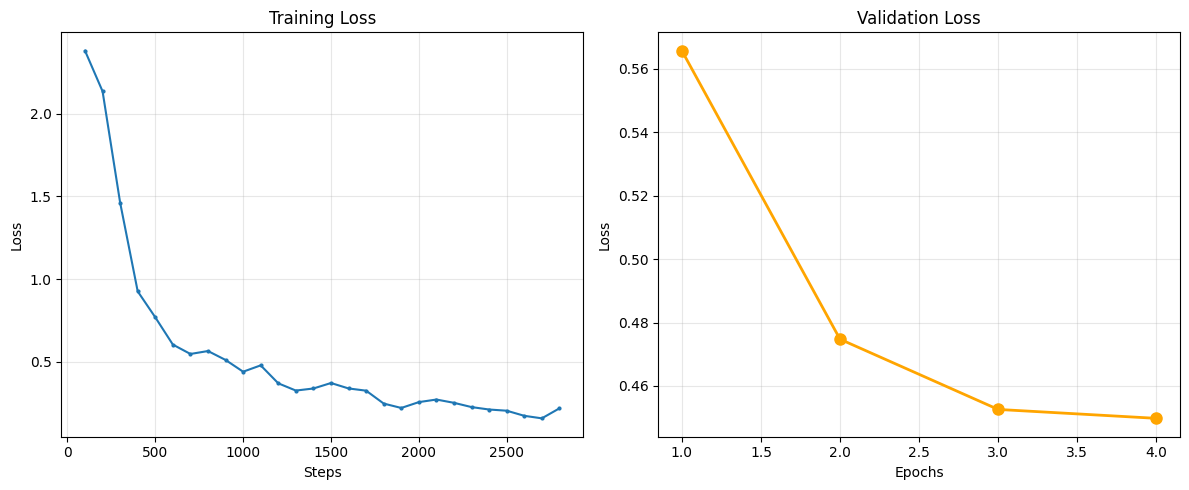

In [22]:
import matplotlib.pyplot as plt

# Trích xuất lịch sử training
history = trainer.state.log_history

# Tách train loss và validation metrics
train_losses = []
train_steps = []
eval_losses = []
eval_epochs = []

for entry in history:
    if 'loss' in entry and 'eval_loss' not in entry:  # chỉ train loss
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:  # validation loss
        eval_losses.append(entry['eval_loss'])
        eval_epochs.append(entry['epoch'])

# Tìm best val_loss
if eval_losses:
    best_val_loss = min(eval_losses)
    best_idx = eval_losses.index(best_val_loss)
    
    # Chỉ giữ các epoch từ đầu đến best epoch (bỏ hết các epoch sau khi tăng)
    eval_losses = eval_losses[:best_idx + 1]
    eval_epochs = eval_epochs[:best_idx + 1]
    
    print(f"Best val_loss: {best_val_loss:.4f} tại epoch {eval_epochs[-1]:.0f}")

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))

# Train loss theo steps
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_losses, marker='o', markersize=2, linewidth=1.5)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

# Val loss theo epochs
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_losses, marker='o', color='orange', linewidth=2, markersize=8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Đánh giá trên test set

In [12]:
test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("Test metrics:")
print(test_metrics)


Test metrics:
{'eval_loss': 0.49863046407699585, 'eval_accuracy': 0.8705985915492958, 'eval_f1': 0.8689541523924028, 'eval_runtime': 5.8657, 'eval_samples_per_second': 193.669, 'eval_steps_per_second': 12.104, 'epoch': 5.0}


In [13]:
from sklearn.metrics import classification_report

preds = trainer.predict(tokenized_datasets["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

target_names = label_encoder.classes_

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


                    precision    recall  f1-score   support

         Chính trị     0.8710    0.7941    0.8308       102
           Du lịch     0.8257    0.8911    0.8571       101
          Giáo dục     0.8302    0.8980    0.8627        98
          Giải trí     0.9245    0.9333    0.9289       105
Khoa học công nghệ     0.8485    0.8317    0.8400       101
        Kinh doanh     0.8230    0.8455    0.8341       110
         Pháp luật     0.9159    0.9245    0.9202       106
          Sức khỏe     0.9138    0.9636    0.9381       110
          Thế giới     0.8952    0.9400    0.9171       100
          Thể thao     0.9895    0.9400    0.9641       100
          Đời sống     0.7241    0.6117    0.6632       103

          accuracy                         0.8706      1136
         macro avg     0.8692    0.8703    0.8687      1136
      weighted avg     0.8693    0.8706    0.8690      1136



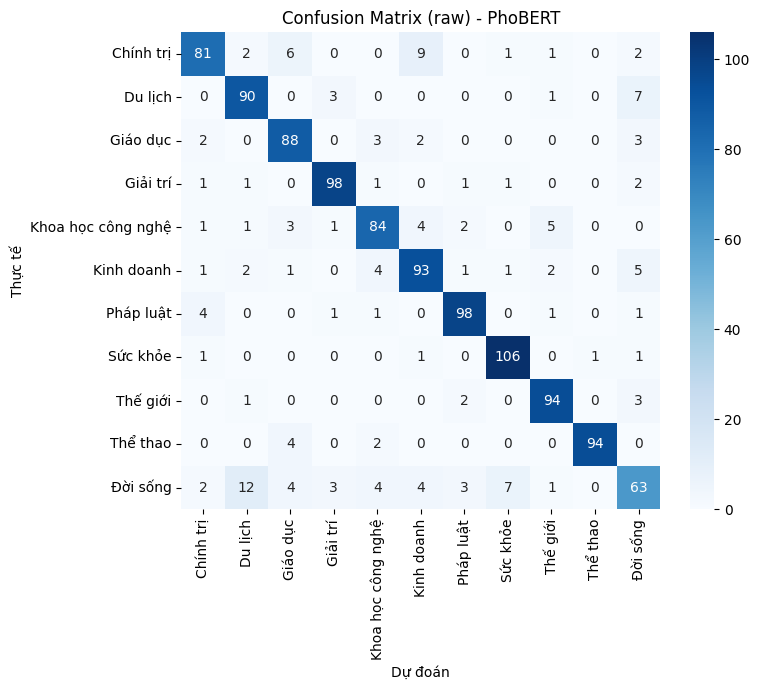

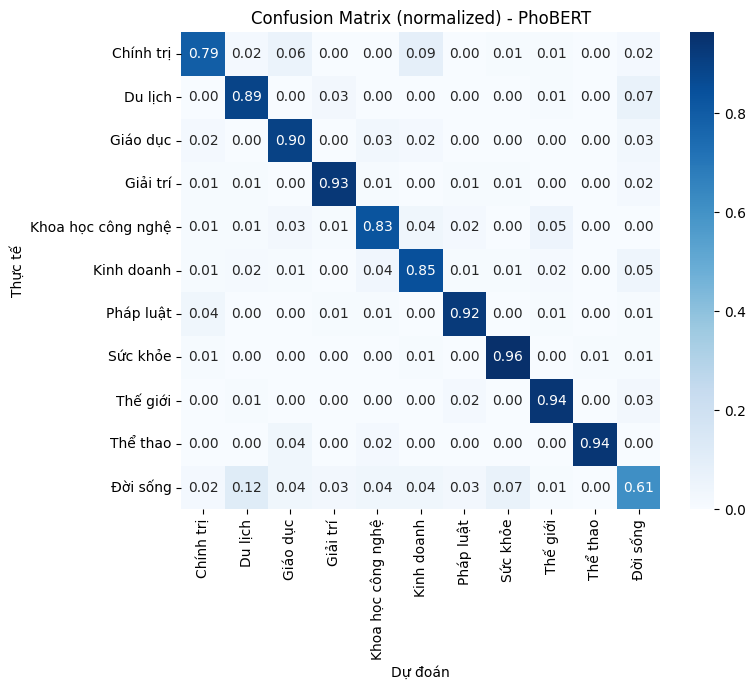

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Lấy predictions
preds = trainer.predict(tokenized_datasets["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

# Lấy danh sách nhãn
labels = sorted(np.unique(y_true))
label_names = [label_encoder.inverse_transform([i])[0] for i in labels]

# Confusion matrix (raw)
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix (raw) - PhoBERT")
plt.tight_layout()
plt.show()

# Confusion matrix (normalized theo hàng)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix (normalized) - PhoBERT")
plt.tight_layout()
plt.show()


Lưu model PhoBERT đã fine-tune

In [15]:
trainer.save_model(str(MODEL_OUT))
tokenizer.save_pretrained(str(MODEL_OUT))

print("Đã lưu model PhoBERT fine-tune tại:", MODEL_OUT)


Đã lưu model PhoBERT fine-tune tại: D:\do-an-tot-nghiep\models\phobert


Hàm inference nhanh (test thử 1 tin)

In [16]:
def predict_subject(text: str) -> str:
    model.eval()
    text = str(text).strip()
    if not text:
        return ""

    enc = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_LENGTH,
    ).to(device)

    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        pred_id = int(torch.argmax(logits, dim=-1).cpu().item())

    label = label_encoder.inverse_transform([pred_id])[0]
    return label

# Ví dụ test:
sample_text = df.iloc[0]["target_text"]
print("Văn bản:", sample_text[:300], "...\n")
print("Nhãn thật:", df.iloc[0]["label"])
print("Dự đoán:", predict_subject(sample_text))


Văn bản: Sáng 5/11, phát biểu khai mạc Hội nghị Trung ương 14, Tổng Bí thư Tô Lâm cho biết tại Hội nghị Trung ương 13, trên cơ sở đề nghị của Bộ Chính trị, Ban Chấp hành Trung ương khóa 13 đã biểu quyết thống nhất, tập trung cao, giới thiệu nhân sự Ban Chấp hành Trung ương khóa 14 - chưa bao gồm các Ủy viên  ...

Nhãn thật: Chính trị
Dự đoán: Chính trị
